In [1]:
from hashlib import md5
import networkx as nx
import json
    

class FamilyTree:
    """
    A class representing a simple database of a family.
    Each person is represented by a tuple (name, gender).
    Must be initialized with the family founder.
    New members can be added as children or spouses of existing members.
    Supports finding the relation between any two family members.
    Can be saved to / loaded from a json file.
    """
    def __init__(self, name, gender):
        self._graph = nx.DiGraph()
        self._graph.add_node((name, gender))
        self._construct_automaton()

    def _construct_automaton(self):
        """
        Builds a self._auto digraph which is later used as an automaton in _analyse_path method.
        """
        familyDict = {
            "self":             {"CHILD":"child", "PARENT":"parent", "MARRIED":"spouse"},
            "child":            {"CHILD":"grandchild", "MARRIED":"child-in-law"},
            "parent":           {"CHILD":"sibling", "PARENT":"grandparent"},
            "spouse":           {"PARENT":"parent-in-law"},
            "parent-in-law":    {"CHILD":"sibling-in-law"},
            "grandchild":       {"MARRIED":"grandchild-in-law"},
            "sibling":          {"CHILD":"nephew/niece", "MARRIED":"sibling-in-law"},
            "grandparent":      {"CHILD":"uncle/aunt", "PARENT":"grandgrandparent"},
            "uncle/aunt":       {"CHILD":"cousin", "MARRIED":"uncle/aunt"},
            "grandgrandparent": {"CHILD":"grandaunt"},
            "sibling-in-law":   {"CHILD":"nephew/niece", "PARENT":"parent-in-law","MARRIED":"sibling-in-law"},
        }
        self._auto = nx.DiGraph()
        for st1 in familyDict.keys():
            for lbl in familyDict[st1].keys():
                st2 = familyDict[st1][lbl]
                self._auto.add_edge(st1, st2, label=lbl)
    
    def give_birth(self, name, gender, pname):
        """
        Adds a new member as a child of existing members
        Arguments:
        name - child's name
        gender - child's gender
        pname - name of one of child's parents (the parent must be married)
        """
        if not pname in (n[0] for n in self._graph.nodes()):
            raise Exception("No {} in this family".format(pname))
        parent1 = self._find_person(pname)
        if not "MARRIED" in (e[2] for e in  self._graph.out_edges(parent1, data="label")):
            raise Exception("{} is not married".format(pname))
        parent2 = next(e for e in self._graph.out_edges(parent1, data="label") if e[2] == 'MARRIED')[1]
        child = (name, gender)
        for p in parent1, parent2:
            self._graph.add_edge(child, p, label="PARENT")
            self._graph.add_edge(p, child, label="CHILD")
        
    def marry(self, hname, wname):
        """
        Adds a new family member as a spouse of an existing one
        Receives husband's and wife's names as hname and wname arguments respectively.
        Exactly one of the two must be a member of the family before calling the method.
        """
        husband = (hname, 'male')
        wife = (wname, 'female')
        found = 0
        for p in husband, wife:
            if p in self._graph.nodes():
                found += 1
                if "MARRIED" in (e[2] for e in self._graph.out_edges(p, data="label")):
                    spouse = self._graph.out_edges(p)["MARRIED"][1]
                    raise Exception("{} is already married to {}".format(p, spouse))
        if found == 0:
            raise Exception("Neither {} nor {} are in the family".format(hname, wname))
        if found == 2:
            raise Exception("{} and {} cannot be married - they are relatives".format(hname, wname))
        self._graph.add_edge(husband, wife, label='MARRIED')
        self._graph.add_edge(wife, husband, label='MARRIED')
        
    def _find_person(self, name):
        """
        Returns a person with a given name, None if not found
        """
        matches = tuple(filter(lambda n : n[0] == name, self._graph.nodes()))
        return None if len(matches) == 0 else matches[0]
        
    def who_is_to(self, per1, per2):
        """
        Returns relation between two family members (e.g. grandfather, aunt etc.), "far relative" if the distance is too long.
        """
        for per in (per1, per2):
            if not per in (n[0] for n in self._graph.nodes()):
                return "No {} in this family".format(per)
        p1, p2 = (self._find_person(per) for per in (per1, per2))
        path = nx.shortest_path(self._graph, p1, p2)
        return self._analyse_path(path, p1[1])

    def _get_edges_from_path(self, path):
        """
        Receives a sequence of nodes in the path, yields directed edges connecting them.
        """
        if len(path) > 0:
            current = path[0]
            for node in path[1:]:
                yield self._graph[current][node]['label']
                current = node

    def _analyse_path(self, path, gender):
        """
        This method uses digraph constructed in _construct_automaton() as an automaton accepting the           edges of the passed path as an input sequence.
        """
        state = 'self'
        for edge in self._get_edges_from_path(path):
            try:
                state = next(s for s in self._auto.successors(state) if self._auto[state][s]['label'] == edge)
            except StopIteration:
                return "far relative"
        return {
            "self":             ("self", "self"),
            "child":            ("son", "daughter"),
            "parent":           ("father", "mother"),
            "spouse":           ("husband", "wife"),
            "parent-in-law":    ("father-in-law", "mother-in-law"),
            "grandchild":       ("grandson", "granddaughter"),
            "sibling":          ("brother", "sister"),
            "grandparent":      ("grandfather", "grandmother"),
            "uncle/aunt":       ("uncle", "aunt"),
            "grandgrandparent": ("grandgrandfather", "grandgrandmother"),
            "sibling-in-law":   ("brother-in-law", "sister-in-law")
        }.get(state, "far relative")[{"male":0, "female":1}.get(gender)]
    
    def draw(self):
        """
        Draws family tree as a graph
        Nodes:  blue for males, red for females
        Edges:  black for parent-child relations, red for marriage
        """
        marryedges = tuple(filter(lambda e : e[2] == 'MARRIED', self._graph.edges(data="label")))
        parentedges = tuple(filter(lambda e : e[2] == 'PARENT', self._graph.edges(data="label")))
        males=tuple(filter(lambda n : n[1] == 'male', self._graph.nodes()))
        females=tuple(filter(lambda n : n[1] == 'female', self._graph.nodes()))
        pos = nx.drawing.layout.kamada_kawai_layout(self._graph)
        nx.draw_networkx_nodes(self._graph, pos, males, with_labels=True, node_color='b')
        nx.draw_networkx_nodes(self._graph, pos, females, with_labels=True, node_color='r')
        nx.draw_networkx_edges(self._graph, pos, marryedges, edge_color='r')
        nx.draw_networkx_edges(self._graph, pos, parentedges)
        nx.draw_networkx_labels(self._graph, pos, {n:n[0] for n in self._graph.nodes()})
    
    def save(self, filename):
        """
        Saves family tree's graph into a 'filename' with json format
        """
        with open(filename, 'w') as file:
            file.write(json.dumps(nx.node_link_data(self._graph)))


def load_json(filename):
    """
    Returns an instance of FamilyTree with a graph defined in 'filenamr' with json format
    """
    data = dict()
    with open(filename, 'r') as file:
        data = json.loads(file.read())
    ret = FamilyTree("", "")
    ret._graph = nx.node_link_graph(data)
    return ret


if __name__ == "__main__":
    # tree = load_json("ftree.json")
    tree = FamilyTree("Grandfather", "male")
    tree.marry("Grandfather", "Grandmother")
    tree.give_birth("Mother", "female", "Grandfather")
    tree.give_birth("Uncle", "male", "Grandmother")
    tree.marry("Father", "Mother")
    tree.marry("Uncle", "Aunt")
    tree.give_birth("Sister", "female", "Father")
    tree.give_birth("Me", "male", "Father")
    tree.give_birth("Cousin", "female", "Uncle")
    tree.who_is_to("Father", "Aunt")
    tree.save("ftree.json")
        

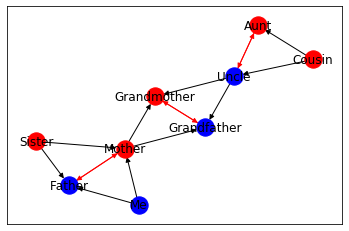

In [2]:
tree.draw()